# `Perspective-n-Points` algorithm

In [1]:
import mujoco_py
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass, set_env_joint_configuration, get_env_joint_names, print_env_joint_infos, get_env_obj_names, set_env_obj
from util import rpy2r,pr2t,t2pr
from util_fk import *
import cv2

np.set_printoptions(precision=2)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Ready.")

Done.
Ready.


### Parse `UR5e`

In [2]:
env = MuJoCoParserClass(name='UR5e',xml_path='../asset/ur5e/UR5_rg2_gripper.xml')
print ("[%s] parsed."%(env.name))

[UR5e] parsed.


### Get camera informations

In [3]:
cam_infos = env.set_cam_infos(cam_distance  = 0.0,
                    cam_azimuth   = 0.0,
                    cam_elevation = -90.0,
                    cam_lookat    = [1.4,0.0,2.0])
cam_infos

{'cam_distance': 0.0,
 'cam_azimuth': 0.0,
 'cam_elevation': -90.0,
 'cam_lookat': array([1.4, 0. , 2. ])}

[0/7] obj_name:[obj_cylinder_1]
[1/7] obj_name:[obj_cylinder_2]
[2/7] obj_name:[obj_cylinder_3]
[3/7] obj_name:[obj_cylinder_1_thick]
[4/7] obj_name:[obj_cylinder_2_thick]
[5/7] obj_name:[obj_cylinder_3_thick]
[6/7] obj_name:[obj_box_1]


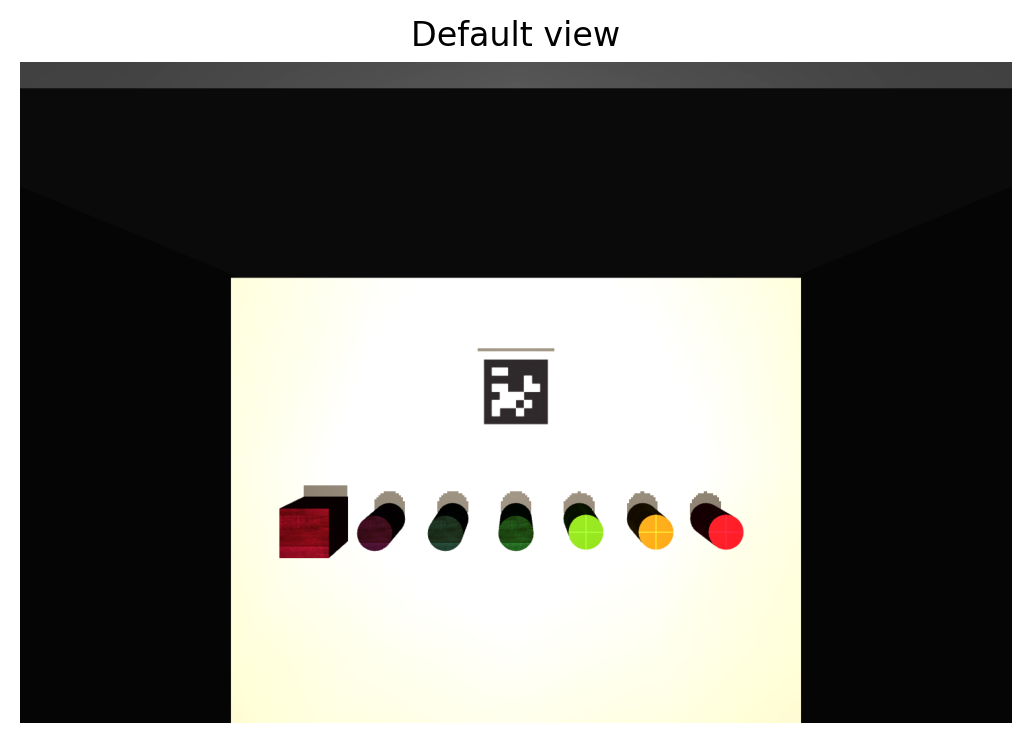

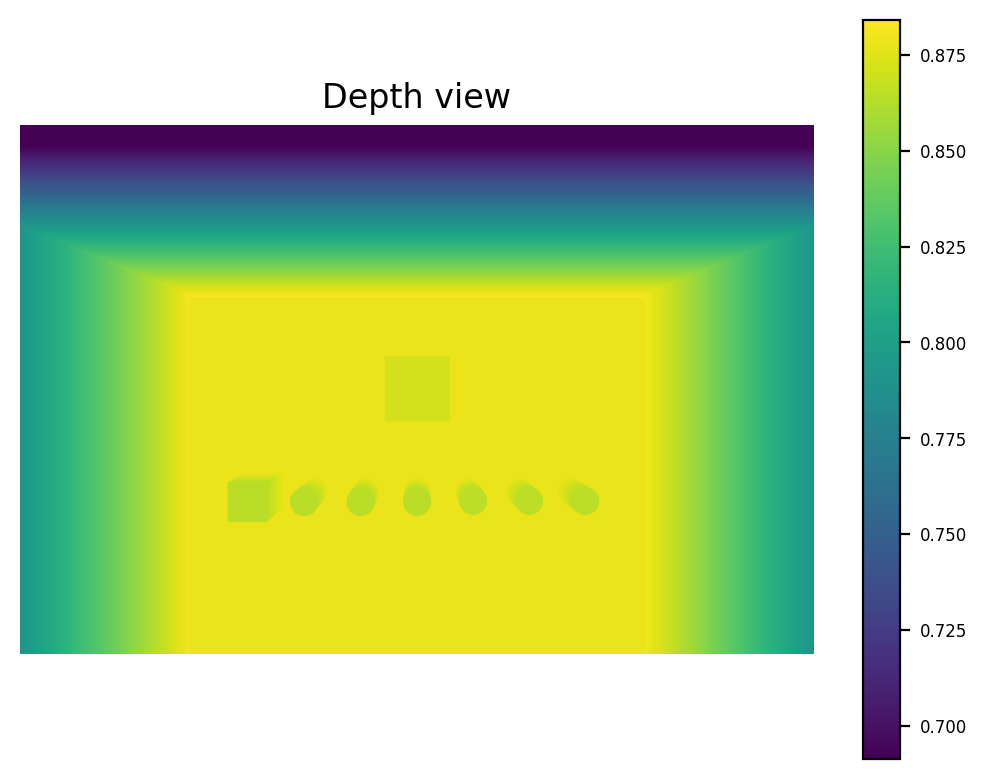

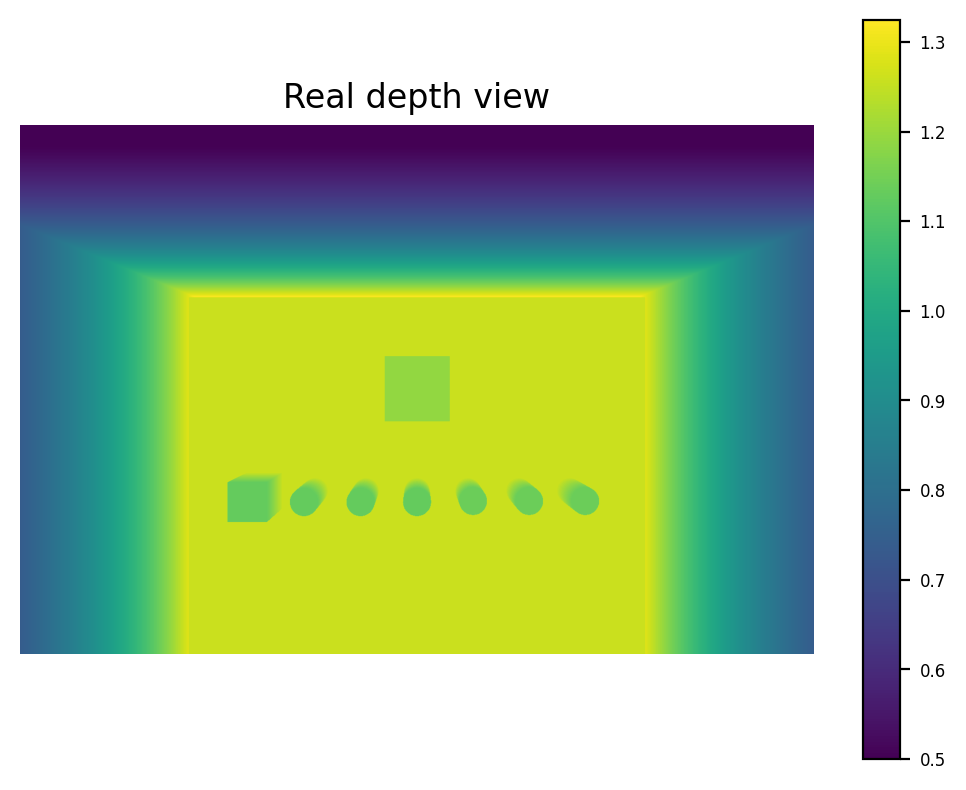

In [71]:
import math

# Check available objects whose names start with 'obj_'

obj_names = get_env_obj_names(env,prefix='obj_') # see objects
for obj_idx,obj_name in enumerate(obj_names):
    print ("[%d/%d] obj_name:[%s]"%(obj_idx,len(obj_names),obj_name))

# Initialize position
colors = [plt.cm.gist_rainbow(x) for x in np.linspace(0,1,len(obj_names))]
for obj_idx,obj_name in enumerate(obj_names):
    obj_pos   = [1.2,-0.3+0.1*obj_idx,0.8]
    obj_quat  = [0,0,0,1]
    obj_color = colors[obj_idx]
    set_env_obj(env=env,obj_name=obj_name,obj_pos=obj_pos,obj_quat=obj_quat,obj_color=obj_color)

# Set Joint Configurations
init_configurations = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2 ]
set_env_joint_configuration(env, init_configurations, prefix='ur_')

# update object locations
env.forward(INCREASE_TICK=False)

width = 1500
height = 1000
ur_joint_idx = np.array([0, 1, 2, 3, 4, 5, 6], dtype=np.int32)

# env.sim.data.qpos[:8] = [-math.pi/2, -3*math.pi/4, 3*math.pi/4, math.pi/2, math.pi/4, -math.pi/2, 0, 0] 
# torque = [-math.pi/2, -6*math.pi/8, 2*math.pi/3, math.pi/2, math.pi/4, 0, False] 
# env.step(ctrl=torque, ctrl_idxs=ur_joint_idx)

for _ in range(2):
    img = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=False, camera_name="track")
    img_depth = env.render_scene(mode='rgb_array', cam_infos=cam_infos, width=width, height=height, depth_toggle=True, camera_name="track")
    img_real = np.array(env.depth_2_meters(img_depth))

plt.imshow(img); plt.axis('off')
plt.title("Default view")
plt.show()

plt.imshow(img_depth); plt.axis('off')
plt.title("Depth view")
plt.colorbar()
plt.show()

plt.imshow(img_real); plt.axis('off')
plt.title("Real depth view")
plt.colorbar()
plt.show()

### Get `AprilTag` Informations

In [80]:
import apriltag

detector = apriltag.Detector()
img_BGR = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img_Gray = cv2.cvtColor(img_BGR, cv2.COLOR_BGR2GRAY)

# detections, dimg = detector.detect(fram_gray, return_image=True)
results = detector.detect(img_Gray)

cam_matrix, _, _ = env.camera_matrix_and_pose(width=width, height=height, camera_name="main1")
fx = cam_matrix[0][0]
cx = cam_matrix[0][2]
fy = cam_matrix[1][1]
cy = cam_matrix[1][2]

cam_params = [fx, fy, cx, cy]

# Render the detections on the image
if len(results) > 0:
    for r in results:
        pose, e0, e1 = detector.detection_pose(detection=r, camera_params=cam_params, tag_size=0.06)
        
        poseRotation = pose[:3, :3]
        poseTranslation = pose[:3, 3]


### Convert pixel point to 3d point 

In [73]:
def convert_from_uvd(u, v, d):
    """
        pxToMetre: Constant, Means Camera Property
        cx: Center x of Camera
        cy: Center y of Camera
        focalx: Focal length
        focaly: Focal length 
    """
    pxToMetre = 1
    focalx = 1207.10
    focaly =  1207.10
    cx = 750.0
    cy = 500.0
    d *= pxToMetre
    x_over_z = (cx - u) / focalx
    y_over_z = (cy - v) / focaly
    z = d / np.sqrt(1. + x_over_z**2 + y_over_z**2)
    x = x_over_z * z
    y = y_over_z * z

    return x, y, z

In [74]:
corner_3d_point = []

for i in range(4):
    corner_u = results[0].corners[i].ravel()[0]
    corner_v = results[0].corners[i].ravel()[1]

    xyz =convert_from_uvd(int(results[0].corners[i][0]), int(results[0].corners[i][1]), img_real[int(corner_u), int(corner_v)])
    corner_3d_point.append(xyz)

corner_3d_point = np.matrix(corner_3d_point, dtype="double")
corner_3d_point

matrix([[ 0.05, -0.04,  1.13],
        [ 0.05,  0.05,  1.13],
        [-0.05,  0.05,  1.26],
        [-0.05, -0.05,  1.26]])

In [75]:
cam_matrix, _, _ = env.camera_matrix_and_pose(width=env.render_width, height=env.render_height, camera_name="main1")

distCoeffs = np.matrix([[
  0.0, 0.0, 0.0, 0.0, 0.0
]])

In [76]:
ret, rotationVec, translationVec = cv2.solvePnP(corner_3d_point, results[0].corners, cam_matrix, distCoeffs)


In [77]:
rotationVec

array([[ 1.97e-02],
       [-5.79e-04],
       [-3.14e+00]])

In [78]:
translationVec

array([[ 1.54e-02],
       [ 1.13e-06],
       [-1.05e-02]])

In [79]:
cubePoints = np.concatenate((corner_3d_point, np.concatenate((corner_3d_point[:,:2], corner_3d_point[:,2:] - 6), 1)))
computedImagePoints, j = cv2.projectPoints(cubePoints, rotationVec, translationVec, cam_matrix, distCoeffs)

print(computedImagePoints)
print(results[0].corners)

[[[701.9  548.93]]

 [[701.9  450.96]]

 [[798.04 451.06]]

 [[798.05 548.83]]

 [[742.39 489.35]]

 [[742.39 511.77]]

 [[718.25 513.42]]

 [[718.25 487.74]]]
[[701.91 548.89]
 [701.9  451.01]
 [798.05 451.01]
 [798.04 548.89]]
